This notebook studies the applicability of b/c-tagging event vetoes on signal samples of representative parameter points.

For 102x, [central Btag recommendations](https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X) provide working points for DeepCSV and DeepFlavour.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [3]:
dataset={
    '4mu/mXX-100_mA-5': dict(files=dataset4mu_['mXX-100_mA-5'], treename='ffNtuplizer/ffNtuple'),
    '4mu/mXX-1000_mA-0p25': dict(files=dataset4mu_['mXX-1000_mA-0p25'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-100_mA-5': dict(files=dataset2mu2e_['mXX-100_mA-5'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25': dict(files=dataset2mu2e_['mXX-1000_mA-0p25'], treename='ffNtuplizer/ffNtuple'),
}

**b tagger**

|       | loose | medium | tight |
|-------|-------|--------|-------|
|DeepCSV|0.1241 | 0.4184 | 0.7527|
|DeepJet|0.0494 | 0.2770 | 0.7264|

In [4]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal datasets')
        quality_axis = hist.Cat('wp', 'working points')
        multiplicity_axis = hist.Bin('multi', '#b-tagged/event', 6, 0, 6)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist('A.U.', dataset_axis, quality_axis, multiplicity_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        deepcsv_b = df['hftagscore_DeepCSV_b']
        
        output['multi'].fill(dataset=dataset, wp='loose', multi=deepcsv_b[deepcsv_b>0.1241].counts)
        output['multi'].fill(dataset=dataset, wp='medium', multi=deepcsv_b[deepcsv_b>0.4184].counts)
        output['multi'].fill(dataset=dataset, wp='tight', multi=deepcsv_b[deepcsv_b>0.7527].counts)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [6]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  6.64items/s]


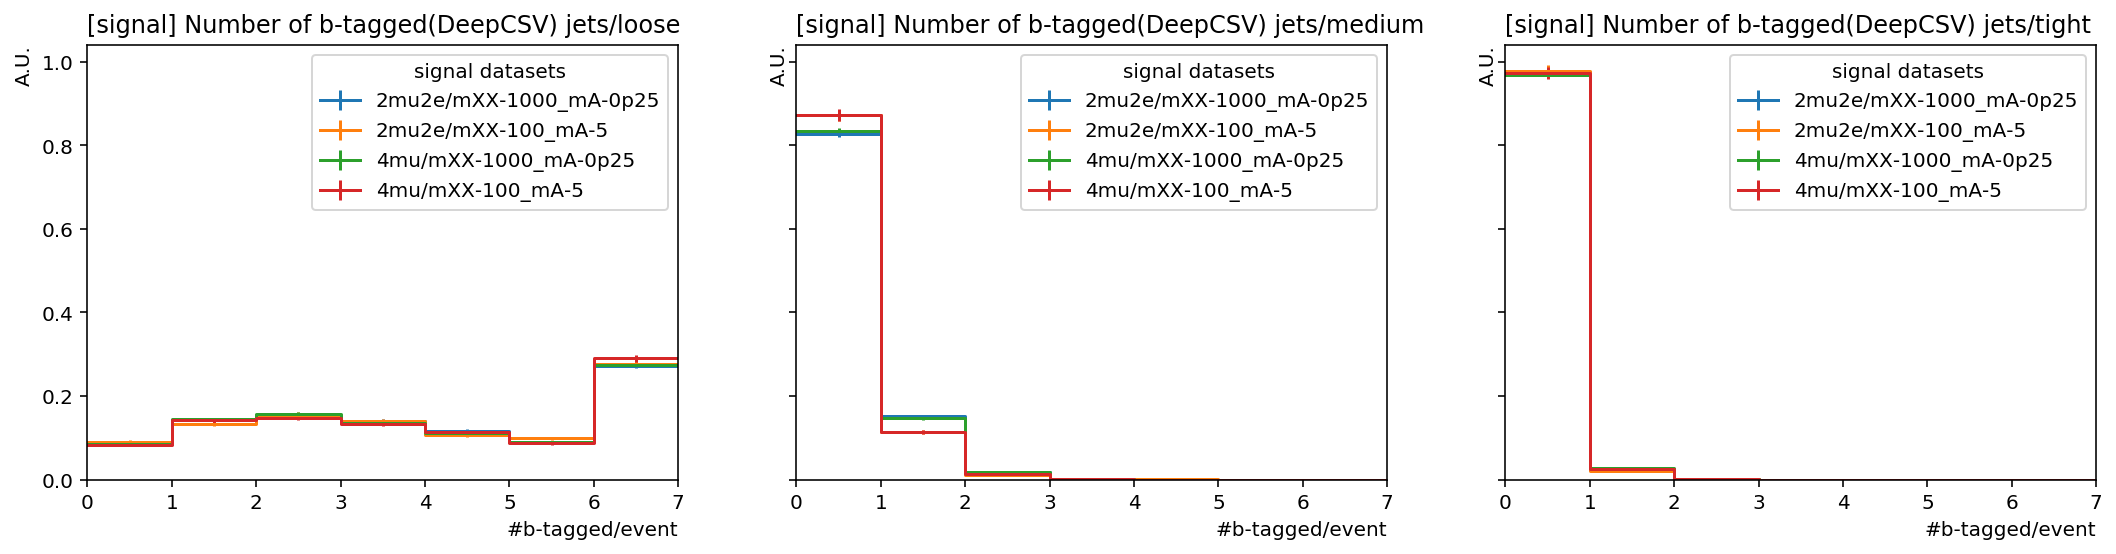

In [23]:
fig, axes = hist.plotgrid(output['multi'], col='wp', overlay='dataset', overflow='over', density=True)
for ax in axes.flatten():
#     ax.set_yscale('log')
    ax.set_title('[signal] Number of b-tagged(DeepCSV) jets/'+ax.get_title(), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");